# PROJECT 1 (PART 3)

In [1]:
# Install libraries
!pip install pyarrow
!pip install pyshp
!pip install shapely==1.7.1
!pip install descartes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shapely: filename=Shapely-1.7.1-cp310-cp310-linux_x86_64.whl size=997336 sha256=768f971f7c07d191f12256956d384d942947029e0d5d234ca162f1fd585a2451
  Stored in directory: /root/.cache/pip/wheels/2e/fa/97/c85f587c35afcaf4a81c481741d36592518d1e50445572f0d4
Successfully built shapely
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.2
    Uninstalling shapely-2.0.2:
      Successfully uninstalled shapely-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
# Import libraries - data processing
import pandas as pd
import numpy as np

# Import libraries -  manipulation of files and downloads
import os
from tqdm.notebook import tqdm

# Import libraries - visualitzation
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

In [3]:
# Global variables
YEARS = [2019, 2020, 2021, 2022]

# Definition of the data path in Google Drive
taxi_data_folder = '/content/drive/MyDrive/data'

# Mount Google Drive (only required if running from Google Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [43]:
# Import clean data
df = pd.read_csv(f'{taxi_data_folder}/clean_data.csv')

## 05. Visualize the locations of the trips

In [ ]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,pickup_day,pickup_hour,pickup_dayofyear,dropoff_month,dropoff_week,dropoff_day,dropoff_hour,dropoff_dayofyear,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,...,1,Tuesday,0,1,1,1,Tuesday,0,1,0.111111
1,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,...,1,Tuesday,0,1,1,1,Tuesday,1,1,0.135278
2,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,...,1,Tuesday,0,1,1,1,Tuesday,1,1,0.489444
3,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,...,1,Tuesday,0,1,1,1,Tuesday,1,1,0.140833
4,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,...,1,Tuesday,0,1,1,1,Tuesday,0,1,0.050000


The data only has the ID of a location, so you need to add the latitude and longitude.

This information is saved in *data/geodata/taxi_zones.shp*.

The next cells can be understood as a black box.

In [6]:
import sys
utils_location = '/content/drive/My Drive/data'
sys.path.append(utils_location)

from utils import get_lat_lon, draw_region_map, draw_zone_map

In [7]:
sf = shapefile.Reader(f'./drive/MyDrive/data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [8]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


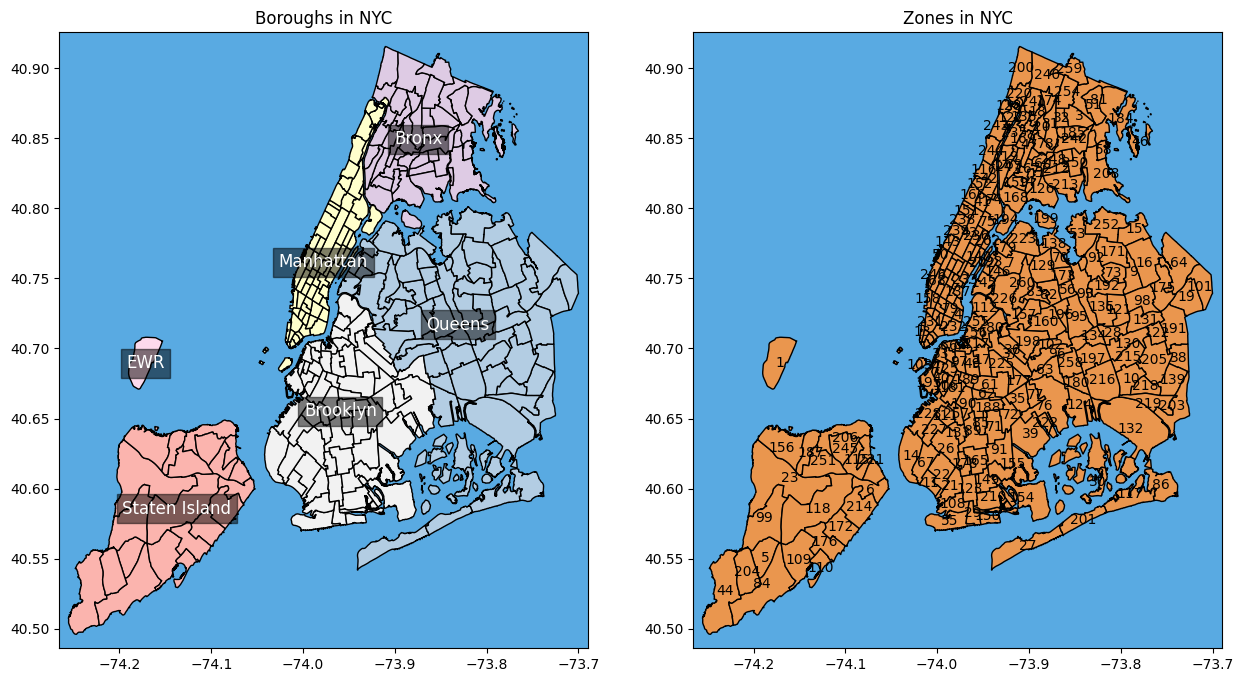

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Now you have two dataframes that you need to join. Use the *pd.merge* function to add the longitude and latitude to the *df* dataframe:

In [25]:
# method 1
# merge = df.merge(df_loc,left_on="PULocationID", right_on="LocationID", suffixes=(None, "_PU"))

We could use the df_loc as a dictionary, and every time we want to check a PU or DO Location_ID check the dictionary, or we could merge into a new dataframe that would have all the information. In our case the merged dataframe is handable and makes the code easier, so I chose this approach:

In [44]:
# method 2
merge = pd.merge(df,df_loc, left_on ="PULocationID", right_on ="LocationID")
columns_to_rename = df_loc.columns
merge.rename(columns={col: col + '_PU' for col in columns_to_rename}, inplace=True)
# Now we add the location for the DropOff
merge = pd.merge(merge, df_loc, left_on="DOLocationID", right_on="LocationID")
merge.rename(columns={col: col + '_DO' for col in columns_to_rename}, inplace=True)

In [45]:
merge.shape

(167861, 37)

In [46]:
merge.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'total_amount', 'year', 'pickup_month', 'pickup_week',
       'pickup_day', 'pickup_hour', 'pickup_dayofyear', 'dropoff_month',
       'dropoff_week', 'dropoff_day', 'dropoff_hour', 'dropoff_dayofyear',
       'trip_duration', 'OBJECTID_PU', 'Shape_Leng_PU', 'Shape_Area_PU',
       'zone_PU', 'LocationID_PU', 'borough_PU', 'longitude_PU', 'latitude_PU',
       'OBJECTID_DO', 'Shape_Leng_DO', 'Shape_Area_DO', 'zone_DO',
       'LocationID_DO', 'borough_DO', 'longitude_DO', 'latitude_DO'],
      dtype='object')

In [47]:
merge.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,longitude_PU,latitude_PU,OBJECTID_DO,Shape_Leng_DO,Shape_Area_DO,zone_DO,LocationID_DO,borough_DO,longitude_DO,latitude_DO
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,...,-73.968222,40.797859,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
1,2019-01-03 09:52:47,2019-01-03 09:57:36,1.0,1.408,151,239,1,5.5,8.55,2019,...,-73.968222,40.797859,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
2,2019-01-04 13:45:10,2019-01-04 13:51:19,1.0,1.760,151,239,1,6.0,8.15,2019,...,-73.968222,40.797859,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
3,2019-01-04 16:49:03,2019-01-04 16:52:53,2.0,1.440,151,239,2,5.0,6.80,2019,...,-73.968222,40.797859,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025
4,2019-01-11 14:00:40,2019-01-11 14:08:25,1.0,1.664,151,239,1,7.0,9.36,2019,...,-73.968222,40.797859,239,0.063626,0.000205,Upper West Side South,239,Manhattan,-73.978732,40.784025


## 06. Which are the areas/zones with more pick-up and drop-off?

In this section, you have to visualize the areas where taxis are most used.

The first step is to sort and save in a variable the most common places in the pick-up and drop-off.

The variables *top_pu* and *top_do* contains a dataframe with columns: 'year', 'PULocationID', and 'count'.

In [60]:
# Pick-up
top_pickups = merge.groupby(["year", "LocationID_PU", "zone_PU"]).size().reset_index()
top_pickups.columns = ["year", "zone", "zone_name", "count"]

In [61]:
top_pickups

,year,zone,zone_name,count
0,2019,1,Newark Airport,2
1,2019,3,Allerton/Pelham Gardens,2
2,2019,4,Alphabet City,154
3,2019,5,Arden Heights,1
4,2019,7,Astoria,105
...,...,...,...,...
708,2022,258,Woodhaven,1
709,2022,260,Woodside,4
710,2022,261,World Trade Center,171
711,2022,262,Yorkville East,490


In [62]:
# Drop-off
top_dropoffs =  merge.groupby(["year", "LocationID_DO", "zone_DO"]).size().reset_index()
top_dropoffs.columns = ['year', "zone", 'zone_name', 'count']
top_dropoffs

,year,zone,zone_name,count
0,2019,1,Newark Airport,170
1,2019,3,Allerton/Pelham Gardens,4
2,2019,4,Alphabet City,357
3,2019,7,Astoria,306
4,2019,8,Astoria Park,1
...,...,...,...,...
939,2022,259,Woodlawn/Wakefield,2
940,2022,260,Woodside,32
941,2022,261,World Trade Center,182
942,2022,262,Yorkville East,586


Print the 5 most frequent zones per year and in each case (pick-up and drop-off).

In [57]:
n_top = 5
def show_top_n(df, n_top = n_top):

    """
    Function that print the most common zones by year
    """
    #df.drop('zone', axis=1, inplace=True)
    for year in YEARS:
      df_year = df[df.year == year]
      #df_year.drop("zone", axis=1, inplace=True)
      print(df_year.sort_values(["count"], ascending=False)[0:n_top])
      print("\n")

Top pickups:

In [63]:
show_top_n(top_pickups, n_top)

     year  zone                     zone_name  count
189  2019   237         Upper East Side South   3488
128  2019   161                Midtown Center   3401
188  2019   236         Upper East Side North   3206
129  2019   162                  Midtown East   2981
147  2019   186  Penn Station/Madison Sq West   2979


     year  zone                     zone_name  count
361  2020   237         Upper East Side South   1097
360  2020   236         Upper East Side North   1076
307  2020   161                Midtown Center    931
308  2020   162                  Midtown East    797
324  2020   186  Penn Station/Madison Sq West    779


     year  zone                     zone_name  count
514  2021   237         Upper East Side South   1495
513  2021   236         Upper East Side North   1296
469  2021   161                Midtown Center   1038
449  2021   132                   JFK Airport    961
482  2021   186  Penn Station/Madison Sq West    954


     year  zone              zone_name  

Top dropoffs:

In [64]:
show_top_n(top_dropoffs, n_top)

     year  zone              zone_name  count
220  2019   236  Upper East Side North   3396
150  2019   161         Midtown Center   3298
221  2019   237  Upper East Side South   3245
159  2019   170            Murray Hill   2529
151  2019   162           Midtown East   2508


     year  zone              zone_name  count
451  2020   236  Upper East Side North   1064
452  2020   237  Upper East Side South    946
385  2020   161         Midtown Center    799
367  2020   141        Lenox Hill West    694
394  2020   170            Murray Hill    672


     year  zone              zone_name  count
684  2021   236  Upper East Side North   1304
685  2021   237  Upper East Side South   1247
615  2021   161         Midtown Center    972
624  2021   170            Murray Hill    873
687  2021   239  Upper West Side South    842


     year  zone                  zone_name  count
919  2022   236      Upper East Side North   1567
920  2022   237      Upper East Side South   1531
851  2022   161 

**Let's see with a heat map which are the most common zones**

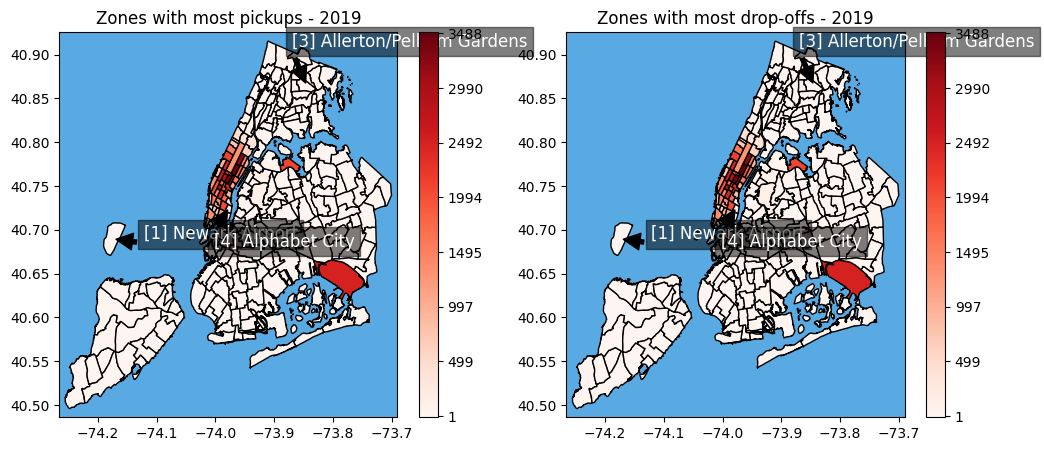

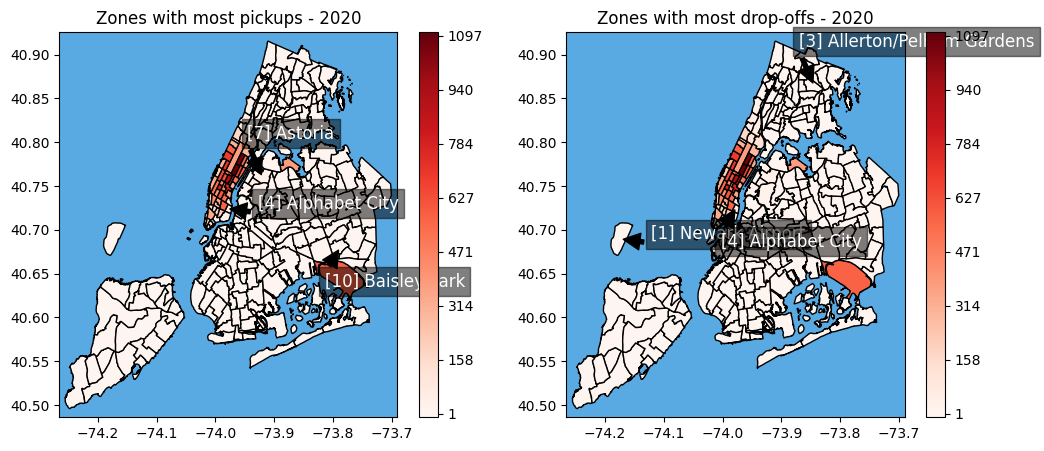

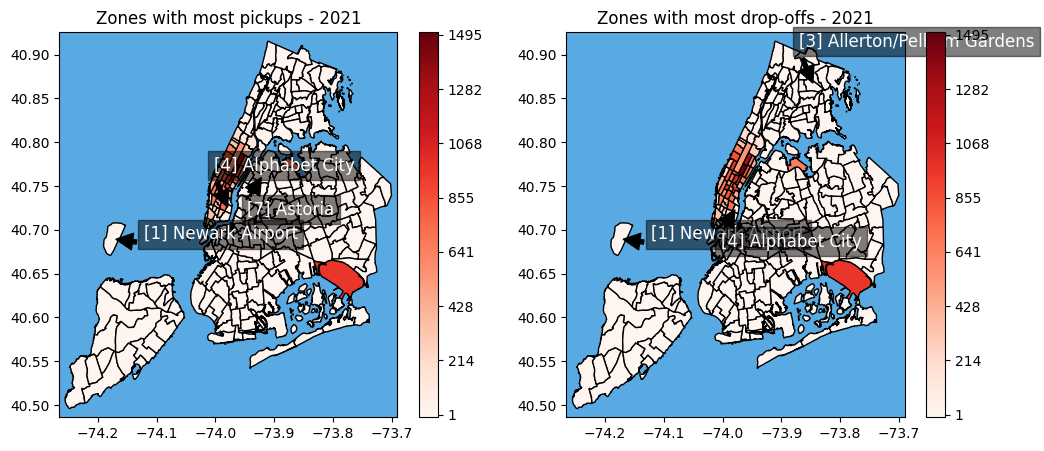

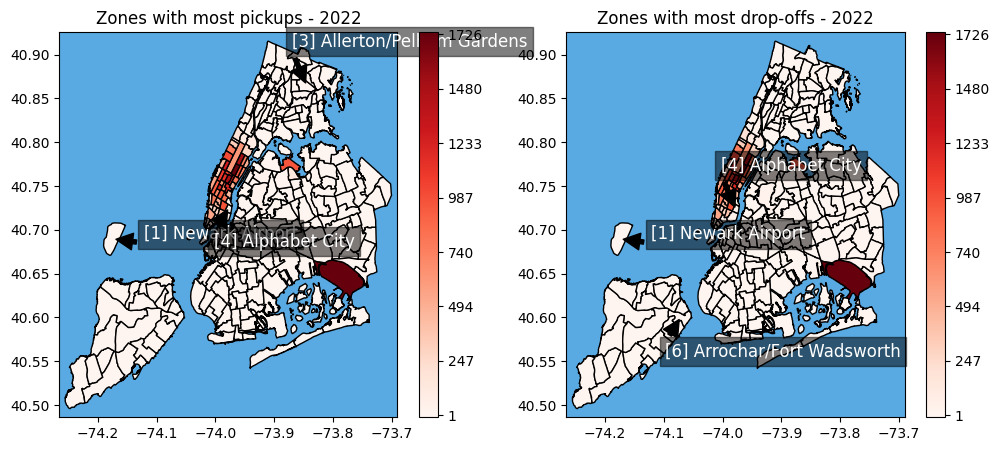

In [65]:
for year in YEARS:
    PUcount = {k:v for k, v in top_pickups[top_pickups.year == year][["zone", 'count']].values}
    #print(PUcount)
    DOcount = {k:v for k, v in top_dropoffs[top_dropoffs.year == year][["zone", 'count']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(DOcount.keys())[:3])
    #break

**Question: Why do you think the Manhattan area has more trips?**

> ANSWER

Manhattan is more densily populated and is also the bussiness center, so it makes sense that there should be more pickups and more dropoffs in Manhattan. We can also see the JFK airport, which takes many passenger from and to the aiport.

## 07. Hospitals

How has the travel destination changed? Are more people going to hospitals?

In the next cell, there is a DataFrame with the most important hospitals in New York and their locations.

In [118]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


Use the latitude and longitude of each hospital and the latitude and longitude of the zone (information in *merge* dataframe) to see the distribution of the hospitals "on the map".

To do this, use a scatter plot. It will be better understood if the points are transparent (parameter *alpha*).

Also, remember how the longitude and latitude data have to be plotted in the figure.

Then repeat the same scatter plot but separated by years.

In [74]:
def scatter_locations(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations"""
    fig, axes = plt.subplots()
    axes.scatter(merge['longitude_DO'], merge['latitude_DO'], alpha=.2)
    axes.scatter(hospitals['Longitude'], hospitals['Latitude'])
    return fig, axes

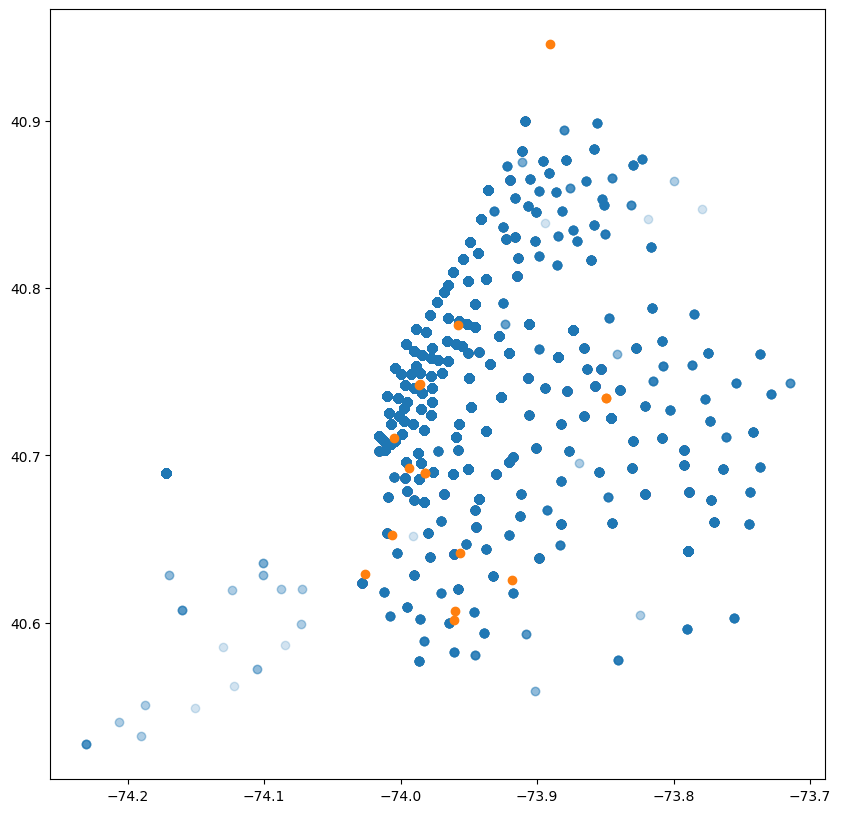

In [76]:
fig, axes= scatter_locations(merge, hospitals)
fig.set_size_inches(10,10)

In [99]:
def scatter_locations_per_year(merge, hospitals):
  """Function showing the distribution of hospitals and taxi destinations per year"""
  fig, axes = plt.subplots(nrows=len(YEARS))
  for idx, year in enumerate(YEARS):

    merge[merge["year"]==year].plot.scatter(x="longitude_DO", y="latitude_DO", alpha=0.1, ax=axes[idx])

    axes[idx].scatter(hospitals['Longitude'], hospitals['Latitude'], color="orange")
    axes[idx].set_title(year)
  return fig, axes

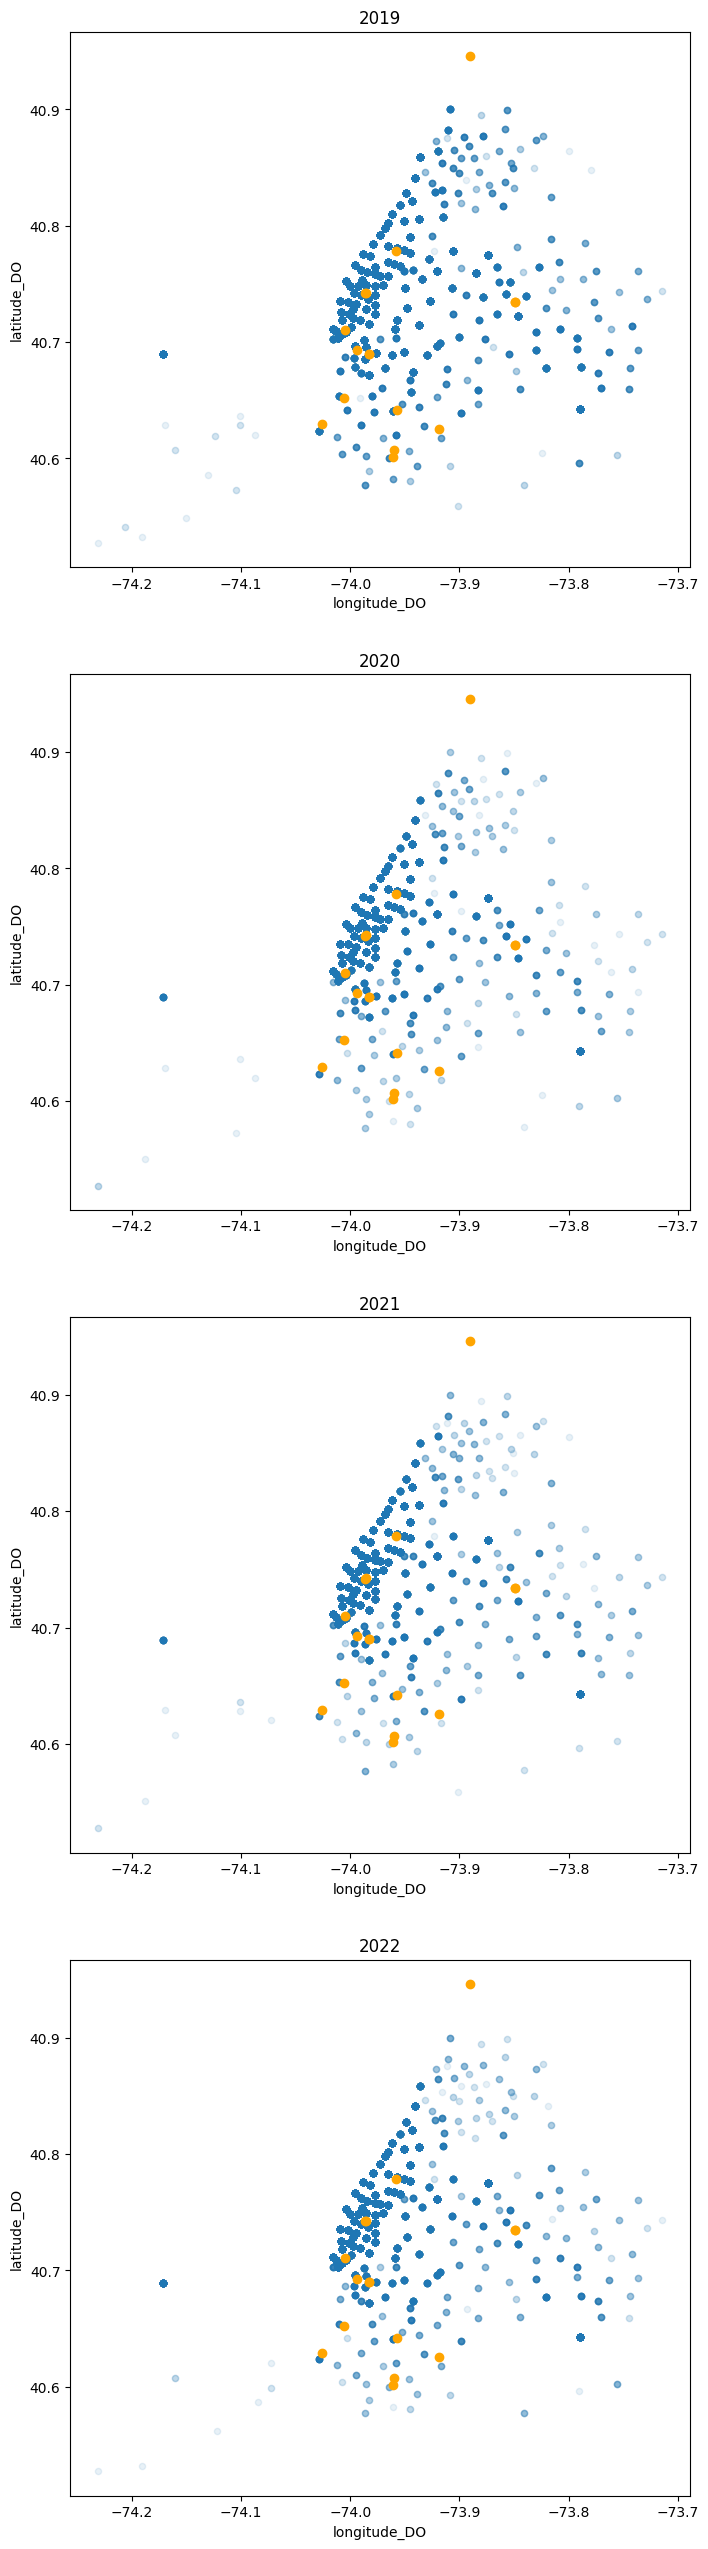

In [100]:
fig, axes = scatter_locations_per_year(merge, hospitals)
fig.set_size_inches(8, 8*4)

**Question: Do you see any behavior?**

>ANSWER


It is not very apparent in the data, but it could be that there are more trips close to the hospitals. This can be seen in more in Brooklyn or Queens, because the trips are less saturated. And we see darker spots next to hospitals.

Of course, this is not an exhaustive dataset because there are many more hospitals.

### 07.1 In which zones are the hospitals?

To find out how trips to hospitals have changed, you need to detect in which zone is each hospital.

To do it, you need to calculate the distances between the hospitals and the zones.

Do not calculate the distance point-to-point, but matrix-wise.

In [103]:
from scipy.spatial import distance_matrix

In [110]:
hospitals_loc = hospitals[['Longitude', 'Latitude']]
loc = df_loc[['longitude', 'latitude']]
dist = distance_matrix(hospitals_loc, loc)

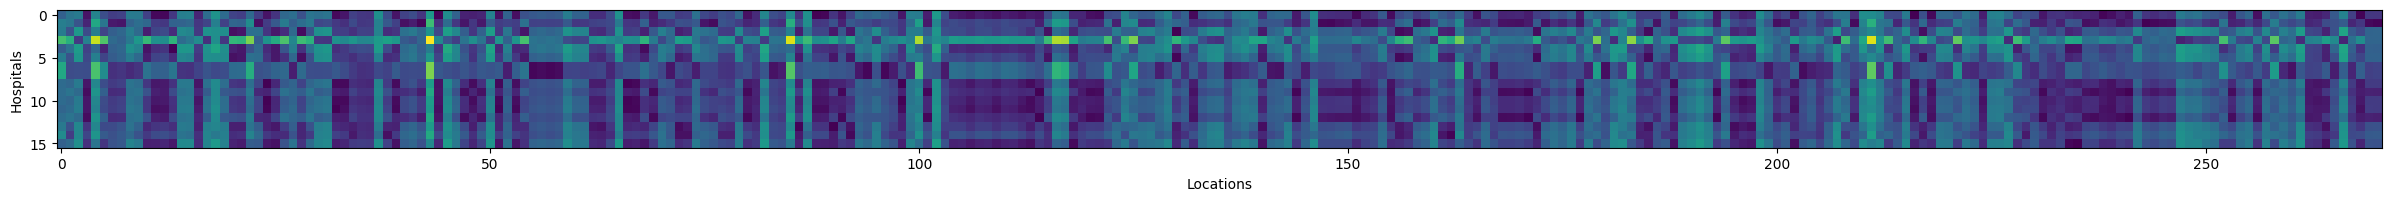

In [112]:
# Distances as an image
plt.figure(figsize=(30, 20))
plt.ylabel("Hospitals")
plt.xlabel("Locations")
plt.imshow(dist)

Find a way to locate the nearest sector based on distances.

In [119]:
hospitals_locations = dist.argmin(axis = 1)
hospitals['LocationID'] = hospitals_locations

In [122]:
hospitals_locations

array([216, 243, 130, 207,  13, 130,  55,  55,  24, 241,  24,  32, 114,
        90, 162, 235])

Text(0, 0.5, 'Closest Zone ID')

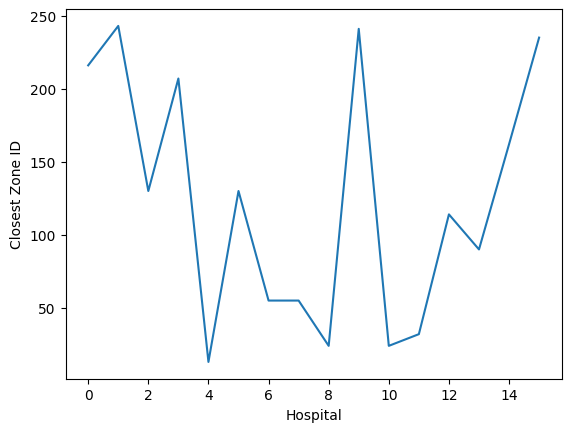

In [120]:
plt.plot(hospitals_locations)
plt.xlabel("Hospital")
plt.ylabel("Closest Zone ID")

In [123]:
hospitals.head()

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,216
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,243
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,130
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,207
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,13


Now that you know the zone of each hospital, visualize how many trips are related to them.

You will assume that all trips in the zone go to the hospital.

Make a single figure with two bar plots showing the number of trips for each year and the % of total trips.

In [135]:
merge_hospitals  = pd.merge(merge, hospitals, left_on ="DOLocationID", right_on ="LocationID")
merge_hospitals

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,Shape_Area_DO,zone_DO,LocationID_DO,borough_DO,longitude_DO,latitude_DO,Place Name,Latitude,Longitude,LocationID
0,2019-01-06 08:11:11,2019-01-06 08:14:26,1.0,0.768,151,24,2,4.5,5.30,2019,...,0.000061,Bloomingdale,24,Manhattan,-73.965522,40.801916,"Professional Gynecological Services, Brooklyn,...",40.689747,-73.982346,24
1,2019-01-06 08:11:11,2019-01-06 08:14:26,1.0,0.768,151,24,2,4.5,5.30,2019,...,0.000061,Bloomingdale,24,Manhattan,-73.965522,40.801916,"Brooklyn Abortion Clinic, Brooklyn, NY, New Yo...",40.689743,-73.982368,24
2,2019-01-17 19:00:25,2019-01-17 19:03:25,2.0,0.800,151,24,2,4.0,5.80,2019,...,0.000061,Bloomingdale,24,Manhattan,-73.965522,40.801916,"Professional Gynecological Services, Brooklyn,...",40.689747,-73.982346,24
3,2019-01-17 19:00:25,2019-01-17 19:03:25,2.0,0.800,151,24,2,4.0,5.80,2019,...,0.000061,Bloomingdale,24,Manhattan,-73.965522,40.801916,"Brooklyn Abortion Clinic, Brooklyn, NY, New Yo...",40.689743,-73.982368,24
4,2019-03-28 22:23:52,2019-03-28 22:27:17,2.0,1.360,151,24,1,5.0,7.56,2019,...,0.000061,Bloomingdale,24,Manhattan,-73.965522,40.801916,"Professional Gynecological Services, Brooklyn,...",40.689747,-73.982346,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447,2019-04-23 07:36:06,2019-04-23 07:51:53,1.0,3.344,32,32,1,11.5,18.50,2019,...,0.000151,Bronxdale,32,Bronx,-73.863860,40.864388,"Brooklyn GYN Place, Brooklyn, NY, USA",40.692696,-73.993584,32
12448,2022-09-12 07:03:49,2022-09-12 07:43:06,1.0,24.960,219,32,1,51.2,58.55,2022,...,0.000151,Bronxdale,32,Bronx,-73.863860,40.864388,"Brooklyn GYN Place, Brooklyn, NY, USA",40.692696,-73.993584,32
12449,2019-02-04 08:13:56,2019-02-04 08:17:30,1.0,1.296,174,32,2,5.0,5.80,2019,...,0.000151,Bronxdale,32,Bronx,-73.863860,40.864388,"Brooklyn GYN Place, Brooklyn, NY, USA",40.692696,-73.993584,32
12450,2021-02-17 17:30:19,2021-02-17 18:32:54,1.0,0.000,91,32,1,56.2,63.12,2021,...,0.000151,Bronxdale,32,Bronx,-73.863860,40.864388,"Brooklyn GYN Place, Brooklyn, NY, USA",40.692696,-73.993584,32


In [156]:
merge_year = merge_hospitals[merge.year==year]
merge_year.groupby(by=["Place Name"]).size()

<ipython-input-156-1fbf376a63b1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merge_year = merge_hospitals[merge.year==year]


Place Name
Americas Holistic Doctor, NYC, NY, USA                            573
Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA             141
Brooklyn GYN Place, Brooklyn, NY, USA                              10
Cosmetic Dentistry Center, NYC, NY, USA                           343
DHD Medical, Brooklyn New York, USA                               996
Envy Smile Dental Spa, Brooklyn, NYC, NY, USA                      20
Manhattan Gastroenterology, NYC, NY, USA                           17
Manhattan Womens Health & Wellness, New York, NY, USA               6
NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA         358
New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA     32
Park Avenue Smiles, Yonkers, NYC, NY, USA                          15
Professional Gynecological Services, Brooklyn, NY, NY, USA        143
Stem Cell Therapy Hospital, NYC, NY, USA                           18
dtype: int64

<Axes: xlabel='Place Name'>

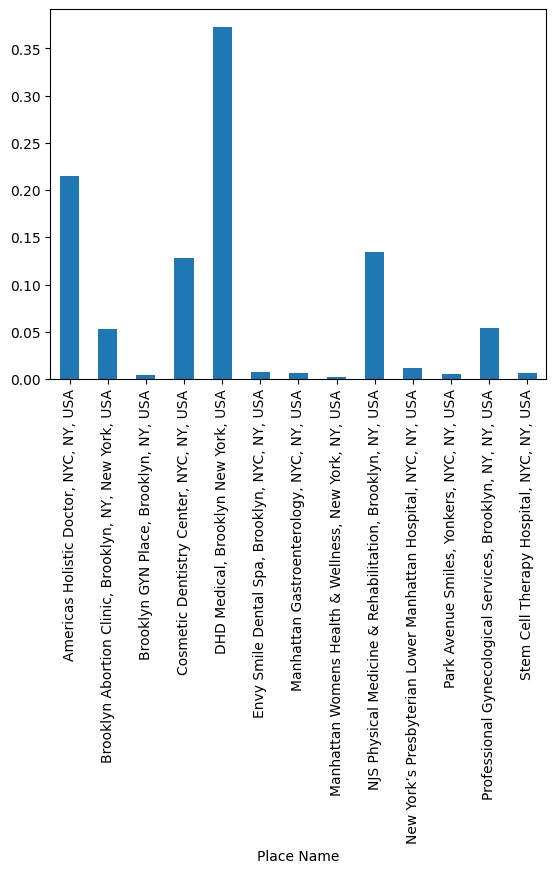

In [158]:
total =merge_year.groupby(by=["Place Name"]).size().sum()
a = merge_year.groupby(by=["Place Name"]).size()/total
a.plot.bar()

In [159]:
def trips_hospitals(merge, hospitals_locations):
  """
  Function that displays a single figure with two bar plots showing the number of trips for each year and the % of total trips.
  """
  # df que entra es el merge
  merge_hospitals  = pd.merge(merge, hospitals_locations, left_on ="DOLocationID", right_on ="LocationID")


  for idx, year in enumerate(YEARS):
    fig, axes = plt.subplots(ncols=2)
    merge_year = merge_hospitals[merge.year==year]
    total = merge_year.groupby(by=["Place Name"]).size().sum()
    merge_year.groupby(by=["Place Name"]).size().plot.bar(ax=axes[0])
    group_norm = merge_year.groupby(by=["Place Name"]).size()/total
    group_norm.plot.bar(ax=axes[1])

  return


<ipython-input-159-6547a2a71ccc>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merge_year = merge_hospitals[merge.year==year]
<ipython-input-159-6547a2a71ccc>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merge_year = merge_hospitals[merge.year==year]
<ipython-input-159-6547a2a71ccc>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merge_year = merge_hospitals[merge.year==year]
<ipython-input-159-6547a2a71ccc>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merge_year = merge_hospitals[merge.year==year]


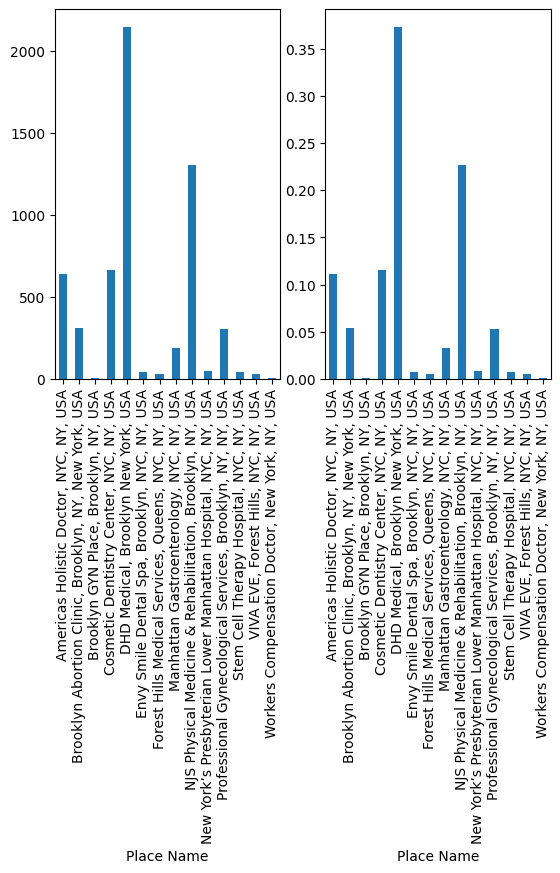

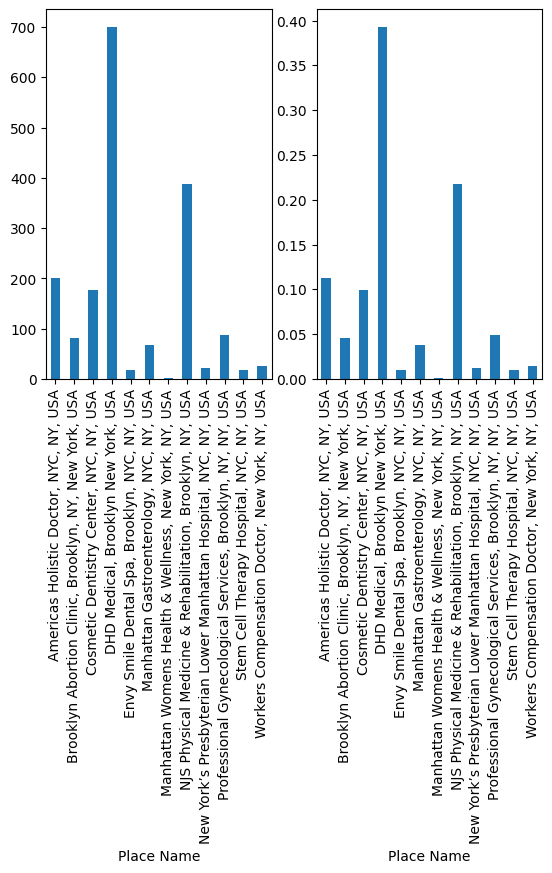

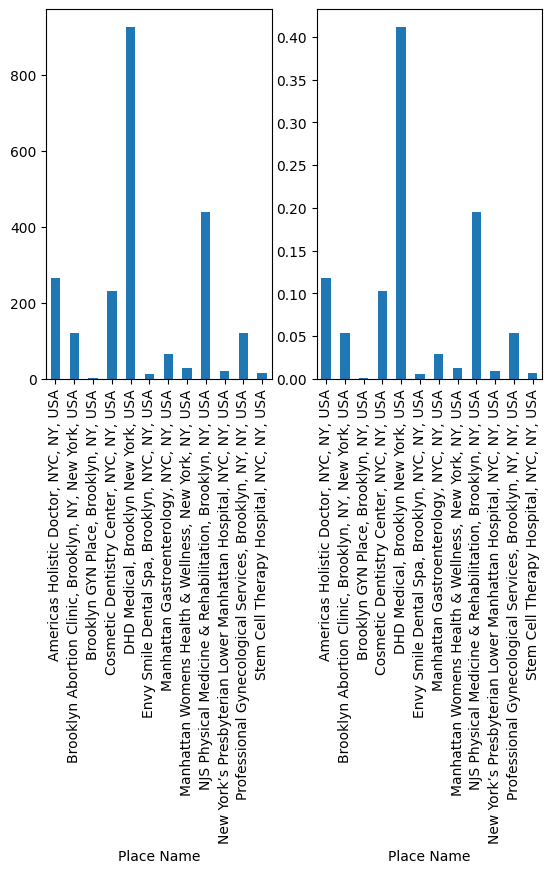

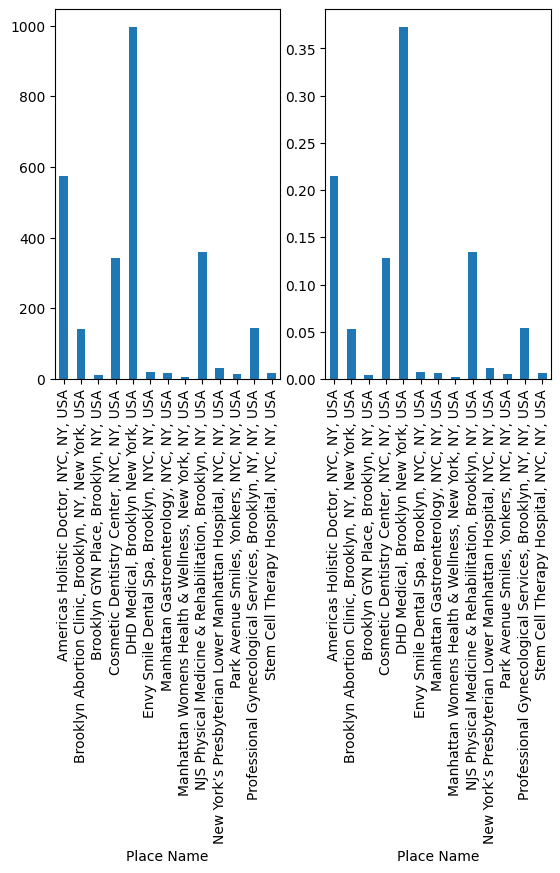

In [160]:
trips_hospitals(merge, hospitals)

## 08. Curiosity killed the cat

In the **first part** you must view and comment on the examples you have removed, such as very long distances, very short distances...

In the **second part** you are free to choose and make visualizations that bring you extra information that has not been seen before.

- Detailed Temporal Analysis: You could investigate further how trips vary throughout the day, week, month or year. Perhaps there are daily (like rush hour) or weekly (weekend vs. weekday) patterns that might be of interest.

- Rates: An analysis of how rates have changed over time could be interesting. Perhaps with less demand, rates have changed.

- More Detailed Spatial Analysis: You could do more spatial analysis, such as identifying the most popular routes, or analyzing the density of pickups/deliveries in different areas.

- Integrate External Data: Perhaps you could integrate weather data to see how the weather affects taxi journeys. You could also consider data about events in the city (such as sports matches, concerts, etc.) that could affect the demand for taxis.

> Answer

We will check if the rate per distance changed during COVID. And assuming the Tip is the difference between fare_amount and total_amount we will look at the evolution of tips across the years, its distribution and the relationship with the fare_amount:

In [164]:
merge.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'total_amount', 'year', 'pickup_month', 'pickup_week',
       'pickup_day', 'pickup_hour', 'pickup_dayofyear', 'dropoff_month',
       'dropoff_week', 'dropoff_day', 'dropoff_hour', 'dropoff_dayofyear',
       'trip_duration', 'OBJECTID_PU', 'Shape_Leng_PU', 'Shape_Area_PU',
       'zone_PU', 'LocationID_PU', 'borough_PU', 'longitude_PU', 'latitude_PU',
       'OBJECTID_DO', 'Shape_Leng_DO', 'Shape_Area_DO', 'zone_DO',
       'LocationID_DO', 'borough_DO', 'longitude_DO', 'latitude_DO'],
      dtype='object')

In [208]:
# Clean fare_amount that are 0
merge = merge[merge["fare_amount"]!=0]
merge = merge[merge["total_amount"]!=0]

In [209]:
merge["rate_per_distance"]=merge["fare_amount"]/merge["trip_duration"]

In [210]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Function that show the distance / duration of trips in the time determined
     :param df: DataFrame with the travel data.
     :param column_data: Name of the column where the values are
     :param columns: Name of the columns (pickup, dropoff)
     :param xlabel: X-axis label
     :param ylabel: Y-axis label
     :param title: Title of the figure
    """
    fig, axes = plt.subplots(ncols=len(columns))
    fig.suptitle(title)
    for idx, column in enumerate(columns):
      # fig, axes = plt.subplots()
      # fig.suptitle(column)
      data  = df.groupby(by=["year", column])[column_data].median().reset_index(name="mean_value")
      sns.lineplot(x=column, y="mean_value", hue='year', data=data, palette=sns.color_palette(n_colors=len(YEARS)), ax=axes[idx])


      # axes.legend()
      axes[idx].set_xlabel(xlabel)
      axes[idx].set_ylabel(ylabel)
      axes[idx].set_title(column)

    # legend only once
    axes[idx].legend(loc="upper left", bbox_to_anchor=(1, 1))

    return fig, axes

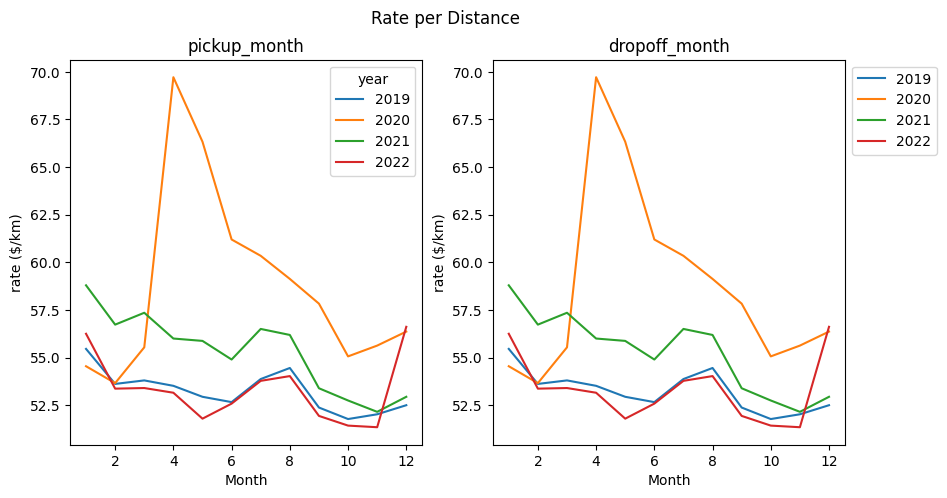

In [211]:
fig, axes = visualize_per_period(merge, "rate_per_distance", ['pickup_month', 'dropoff_month'], "Month", "rate ($/km)", "Rate per Distance")
fig.set_size_inches(10,5)

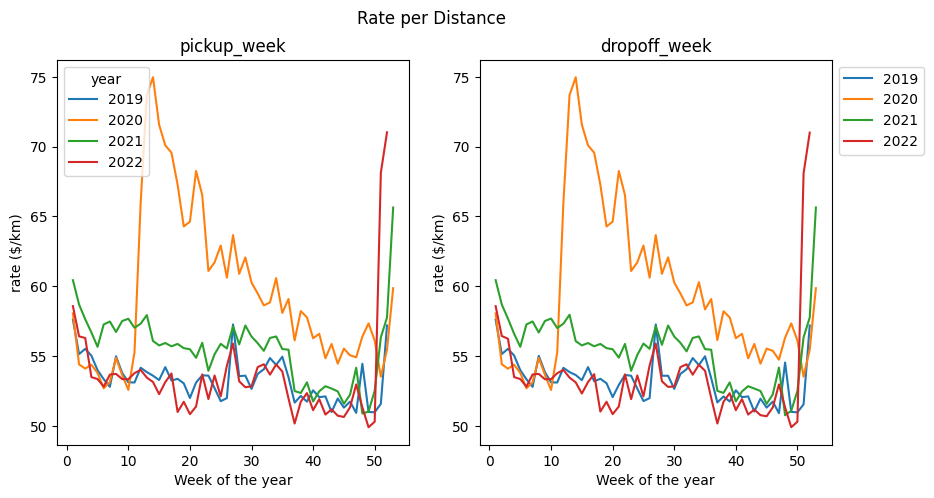

In [212]:
fig, axes = visualize_per_period(merge, "rate_per_distance", ['pickup_week', 'dropoff_week'], "Week of the year", "rate ($/km)", "Rate per Distance")
fig.set_size_inches(10,5)

<ipython-input-213-98dbca8ba894>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40)


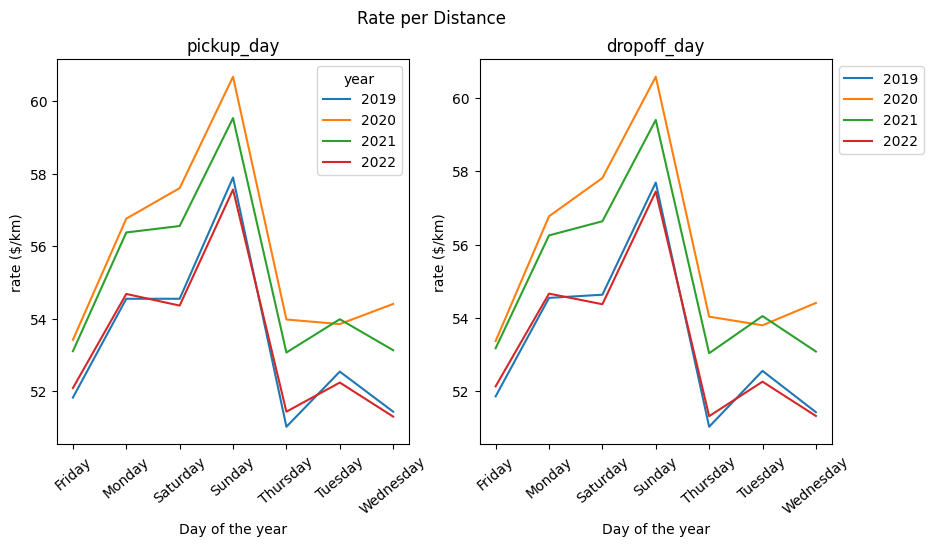

In [213]:
fig, axes = visualize_per_period(merge, "rate_per_distance", ['pickup_day', 'dropoff_day'], "Day of the year", "rate ($/km)", "Rate per Distance")
fig.set_size_inches(10,5)
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

In [214]:
merge["tip_amount"]=merge["total_amount"]-merge["fare_amount"]

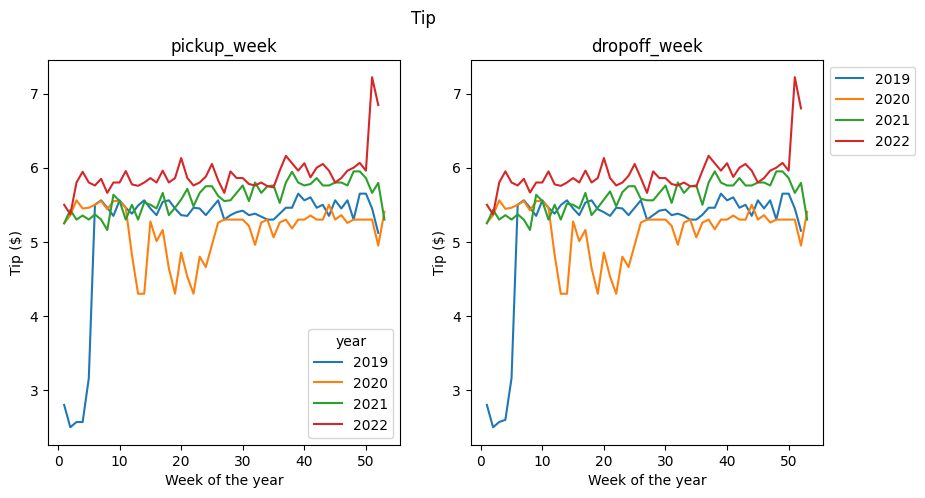

In [215]:
fig, axes = visualize_per_period(merge, "tip_amount", ['pickup_week', 'dropoff_week'], "Week of the year", "Tip ($)", "Tip")
fig.set_size_inches(10,5)

<ipython-input-216-e62d052cd19e>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40)


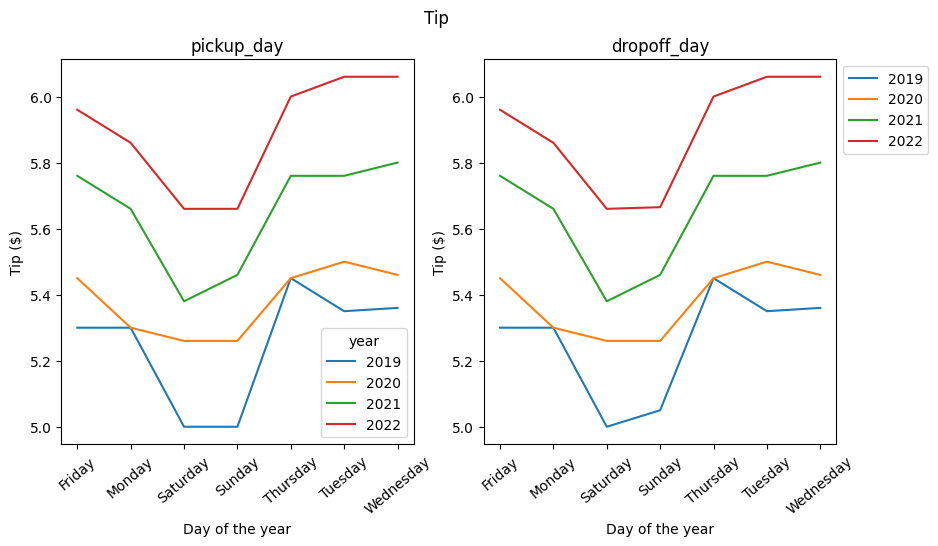

In [216]:
fig, axes = visualize_per_period(merge, "tip_amount", ['pickup_day', 'dropoff_day'], "Day of the year", "Tip ($)", "Tip")
fig.set_size_inches(10,5)
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

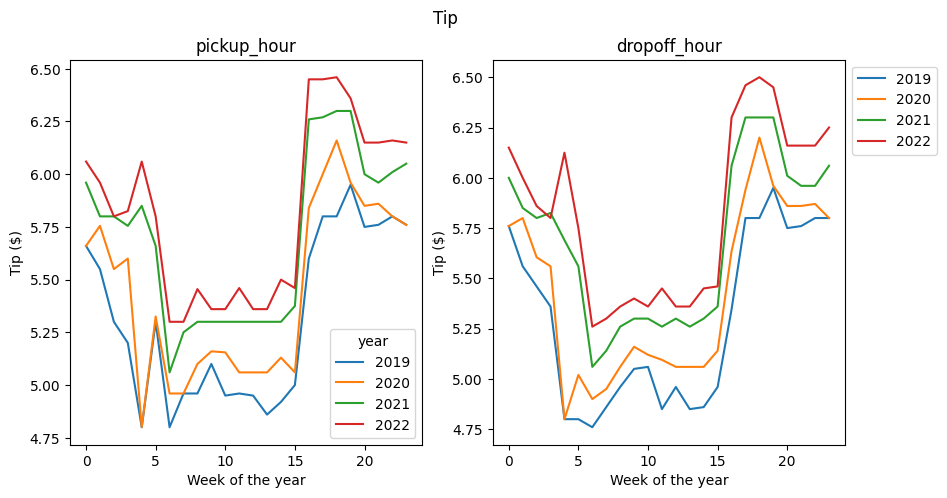

In [235]:
fig, axes = visualize_per_period(merge, "tip_amount", ['pickup_hour', 'dropoff_hour'], "Week of the year", "Tip ($)", "Tip")
fig.set_size_inches(10,5)

array([[<Axes: title={'center': 'fare_amount'}>]], dtype=object)

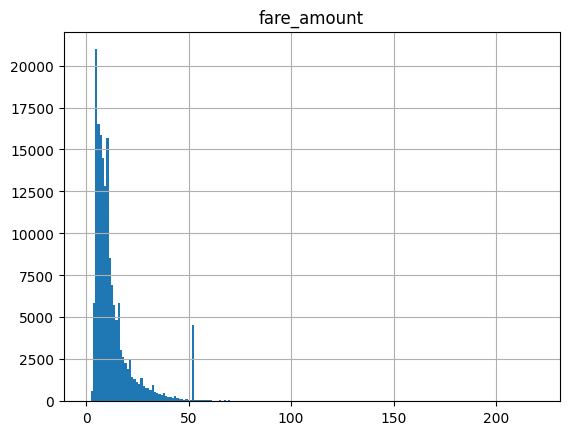

In [226]:
merge[["fare_amount"]].hist(bins=200)

array([[<Axes: title={'center': 'tip_amount'}>]], dtype=object)

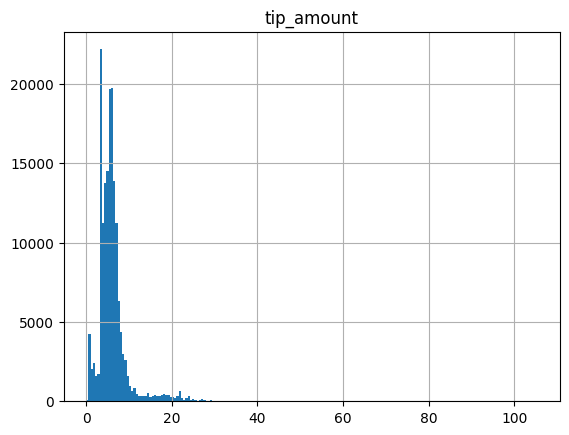

In [228]:
merge[["tip_amount"]].hist(bins=200)

<Axes: xlabel='fare_amount', ylabel='tip_amount'>

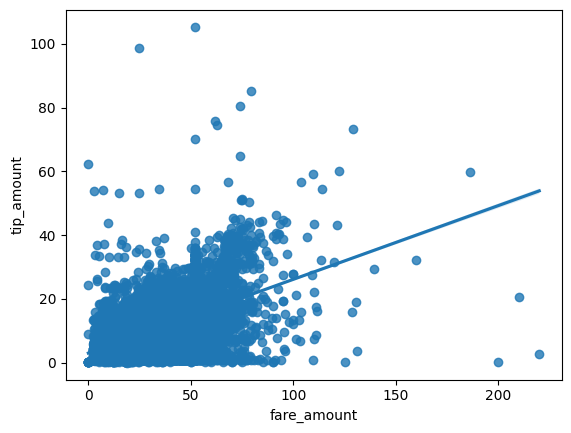

In [231]:
sns.regplot(x="fare_amount", y= "tip_amount", data=merge)

Text(0, 0.5, 'Tip Amount ($)')

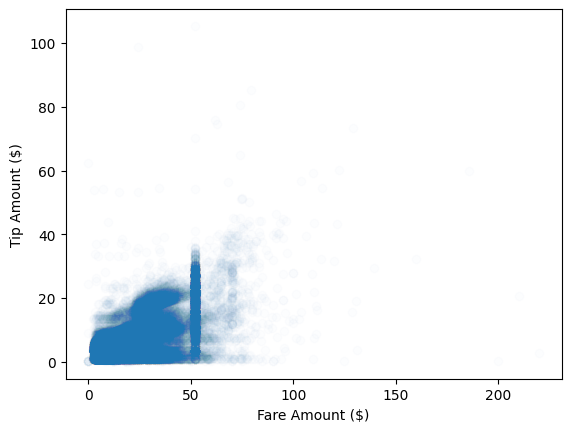

In [234]:
plt.scatter(merge["fare_amount"], merge["tip_amount"], alpha=0.01)
plt.xlabel("Fare Amount ($)")
plt.ylabel("Tip Amount ($)")

> Answer

We see that the rate increased dramatically during the beginning of the corona, reaching 75 USD per km comapred to $ 55 per km on the same period of the year on other years.

We also see that Sundays and January are the most expensive days/months to ride a taxi.

Regarding the tips, we see that during corona times people were a bit more stingy and tipped less.

WE see that after CORONA, years 2021, 2022 people started tipping more and that people tip less on the weekend. And that people tip most in the evening or in the very early morning, probably when going out.


Lastly we looked at the correlation between the fare amount and the tips and we saw a positive correlation. However when comparing the distribution we see that the correlation is less strong for shorter trips (lower fare amounts). And that the distributions are different: The fare amount has a kind of exponential decay for higher fares (makes sense, there are less and less very expensive fares) the tips seem to fall much much faster: very few tips are above $ 20.

We also observe a fix Fare amount of ~60 $ which might correspond to rides to the aiports. In there the tips are higher than what expected from the linear regression.


